In [2]:
from dataset import Dataset
from classificadores import KNN, DMC, PerceptronSimples

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Union

In [3]:
# Conjunto de dados Iris =================================================
dataset = Dataset.from_file( 
    filepath = r"datasets\iris.data", 
    label_column = -1, 
    column_names = ["sepal length", "sepal width", "petal length", "petal width", "class"]
).ensure_numeric_labels().normalize()

print(dataset)
dataset._label_index_to_name

Dataset(instâncias=150, features=4, classes=3)


{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

In [4]:
# Conjunto de dados Dermatologia =================================================
dataset = Dataset.from_file(
    filepath = r"datasets\dermatology.data",
    label_column = -1,
    column_names = ["erythema", "scaling", "definite-borders", "itching", "koebner" "phenomenon", "polygonal papules", "follicular papules", "oral-mucosal involvement", "knee elbow involvement", "scalp involvement", "family history", "melanin incontinence", "eosinophils in the infiltrate", "pnl infiltrate", "fibrosis of the papillary dermis", "exocytosis", "acanthosis", "hyperkeratosis", "parakeratosis", "clubbing of the rete ridges", "elongation of the rete ridges", "thinning of the suprapapillary epidermis", "spongiform pustule", "munro microabcess", "focal hypergranulosis", "disappearance of the granular layer", "vacuolisation and damage of the basal layer", "spongiosis", "saw-tooth appearance of retes", "follicular horn plug", "perifollicular parakeratosis", "inflammatory monoluclear infiltrate", "band-like infiltrate", "age", "class"]
).normalize()

print(dataset)

Dataset(instâncias=358, features=34, classes=6)


In [5]:
# Conjunto de dados Vinho =================================================
dataset = Dataset.from_file( 
    filepath = r"datasets\wine.data", 
    label_column = 0, 
    column_names = ["class", "Alcohol", "Malicacid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols","Proanthocyanins", "Color intensity", "Hue", "0D280 0D315 of diluted wines", "Proline"]
).normalize().move_label_to_end()

print(dataset)

Dataset(instâncias=178, features=13, classes=3)


In [6]:
# Conjunto de dados Coluna Vertebral =================================================
dataset = Dataset.from_file( 
    filepath = r"datasets\column_3C.dat", 
    label_column = -1,
    delimiter = " ",  
    column_names = ["pelvic incidence", "pelvic tilt", "lumbar lordosis angle", "sacral slope", "pelvic radius", "degree spondylolisthesis", "class"]
).ensure_numeric_labels().normalize()

print(dataset)
dataset._label_index_to_name

Dataset(instâncias=310, features=6, classes=3)


{0: 'DH', 1: 'SL', 2: 'NO'}

In [7]:
dataset.data

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,degree spondylolisthesis,class
0,-0.288580,0.039657,-0.541614,-0.498242,-0.385095,-0.949674,0.0
1,-0.750965,-0.406574,-0.802756,-0.710716,-0.046564,-0.927281,0.0
2,-0.176698,0.027867,-0.354036,-0.384786,-0.227659,-0.964944,0.0
3,-0.167631,0.114684,-0.457491,-0.421247,-0.316271,-0.896322,0.0
4,-0.545525,-0.421222,-0.743691,-0.506015,-0.180772,-0.911639,0.0
...,...,...,...,...,...,...,...
305,-0.580440,-0.279385,-0.606229,-0.612808,0.018819,-0.968296,2.0
306,-0.463927,-0.025723,-0.727582,-0.632612,-0.047424,-0.950466,2.0
307,-0.319059,0.044659,-0.424199,-0.530261,0.195612,-0.961127,2.0
308,-0.631559,-0.455520,-0.506354,-0.570794,0.042478,-0.947533,2.0


In [8]:
dataset.determination_matrix()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,degree spondylolisthesis,class
pelvic incidence,1.000000,0.395875,0.514499,0.664158,0.061248,0.407979,0.000845
pelvic tilt,0.395875,1.000000,0.187282,0.003885,0.001067,0.158277,0.044820
lumbar lordosis angle,0.514499,0.187282,1.000000,0.358069,0.006459,0.284798,0.001351
sacral slope,0.664158,0.003885,0.358069,1.000000,0.117064,0.274127,0.014523
pelvic radius,0.061248,0.001067,0.006459,0.117064,1.000000,0.000680,0.055102
degree spondylolisthesis,0.407979,0.158277,0.284798,0.274127,0.000680,1.000000,0.014286
class,0.000845,0.044820,0.001351,0.014523,0.055102,0.014286,1.000000


In [9]:
dataset.vectorize_labels()
dataset.label_encodings

{np.float64(0.0): array([ 1., -1., -1.]),
 np.float64(1.0): array([-1.,  1., -1.]),
 np.float64(2.0): array([-1., -1.,  1.])}

In [10]:
# Separa o conjunto de dados em treinamento e teste
train_dataset, test_dataset = dataset.split()
train_dataset : Dataset 
test_dataset : Dataset

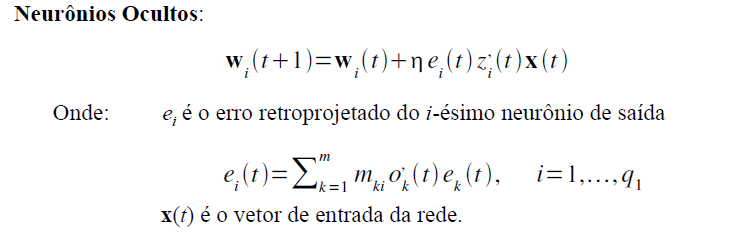

In [ ]:
# Inicio da implementação do Multilayer Perceptron

# W: matriz de pesos dos neurônios ocultos (nº de neurônios ocultos x nº de entradas da rede )
# M: matriz de pesos dos neurônios de saída (nº de neurônios de saída x (nº de neurônios ocultos + 1) )
# q : nº de neurônio ocultos
# m : nº de neurônios de saída = nº de classes
# p : nº de atributos de entrada (nº features + 1)
# u : ativação dos neurônios ocultos
# y : saída dos neurônios ocultos
# z : entrada dos neurônios de saída
# a : ativação dos neurônios de saída
# o : saída dos neurônios de saída

# Obtém uma amostra do conjunto de teste
*features, classe = train_dataset.data.iloc[0]

q = 3                           # Número de neurônios ocultos
m = train_dataset.class_count   # Número de neurônios de saída
p = len(features) + 1           # Número de entradas da rede
eta = 0.1                       # Taxa de aprendizado

# Vetor que representa a classe 
real_output = train_dataset.encode_label( classe )

# Função de ativação usada
activation = lambda x: np.tanh(x);
ddx_activation = lambda x: 1 - activation(x) ** 2

# Monta o vetor de entrada
X_bias = np.r_[features, -1]

# Inicializa o vetor de pesos dos neurônios ocultos
W = np.random.normal( size = (q, p) )

# Inicializa o vetor de pesos dos neurônios de saída
M = np.random.normal( size = (m, q+1) )

# Sentido direto - cálculo da ativação e a saída de cada camada
U = W @ X_bias          # Ativação de cada neurônio oculto
Y = activation( U )     # Saída dos neurônios ocultos

Z = np.r_[ Y, -1 ]      # Prepara as entradas para os neurônios de saída

A = M @ Z               # Ativação dos neurônio de saída
O = activation ( A )    # Saída da camada de saída

# Sentido inverso - atualização dos pesos das camadas
err = real_output - O 

# atualiza os pesos da camada de saída
delta_weights_out = eta * np.outer( err * ddx_activation( A ), Z )
M = M + delta_weights_out

# calcula os erros retropagados para cada neurônio oculto
delta_output = err * ddx_activation( A ) # (m x 1)
output_weights_no_bias_T = M[:, :-1].T # (q x m)
backpropagated_error = output_weights_no_bias_T @ delta_output # (q x 1)

# atualiza os pesos da camada oculta
delta_weights_hidden = eta * np.outer( backpropagated_error * ddx_activation(U), X_bias )
W = W + delta_weights_hidden

In [12]:
PS = PerceptronSimples( train_dataset )
PS.train( 500 )

for index, *point_test, classe in test_dataset:
    classe_prevista = PS.predict( point_test )
    print(f"{index}] Previu {classe_prevista} e era {classe} [{classe_prevista == classe}]")

train_dataset._centroids

Época 1: erros: 128
Época 26: erros: 69
Época 51: erros: 73
Época 76: erros: 68
Época 101: erros: 72
Época 126: erros: 75
Época 151: erros: 64
Época 176: erros: 62
Época 201: erros: 70
Época 226: erros: 63
Época 251: erros: 69
Época 276: erros: 78
Época 301: erros: 66
Época 326: erros: 67
Época 351: erros: 73
Época 376: erros: 58
Época 401: erros: 61
Época 426: erros: 63
Época 451: erros: 63
Época 476: erros: 65
Treinamento encerrado com 71 erros após 500 épocas.
0] Previu 0.0 e era 1.0 [False]
1] Previu 0.0 e era 0.0 [True]
2] Previu 2.0 e era 2.0 [True]
3] Previu 1.0 e era 1.0 [True]
4] Previu 0.0 e era 1.0 [False]
5] Previu 1.0 e era 1.0 [True]
6] Previu 2.0 e era 2.0 [True]
7] Previu 0.0 e era 2.0 [False]
8] Previu 0.0 e era 0.0 [True]
9] Previu 1.0 e era 1.0 [True]
10] Previu 1.0 e era 1.0 [True]
11] Previu 1.0 e era 1.0 [True]
12] Previu 0.0 e era 2.0 [False]
13] Previu 0.0 e era 0.0 [True]
14] Previu 1.0 e era 1.0 [True]
15] Previu 1.0 e era 1.0 [True]
16] Previu 1.0 e era 1.0 [